### Import modules and libraries for use

In [36]:
import nltk
import urllib
import pandas as pd
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from textblob import TextBlob
from nltk.util import ngrams
from collections import Counter
from operator import itemgetter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import os
import re
from sklearn.manifold import TSNE
from collections import defaultdict
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import gensim
import string
from gensim import corpora
import networkx as nx
import matplotlib.pyplot as plt
from plotly.offline import iplot, plot
import plotly.graph_objs as go
import numpy as np
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import pickle

### Get text from Gutenberg

In [2]:
pride = urllib.request.urlopen('https://www.gutenberg.org/files/1342/1342-0.txt').read()
pride_lines = pride.decode('utf8')

### Function to search chapters

In [3]:
def find_chapters(book):
    chapters = {}
    i = 0
    b = 0
    for x in range(1, 62):
        i = book.find("Chapter", + b)
        b = book.find("Chapter", i + 1)
        chapters['Chapter {}'.format(x)] = book[i:b]
    return chapters

### Stopwords, cleaning and lemmatizing 

In [4]:
stop = stopwords.words('english') + ['mr',
                                     'mrs',
                                     'miss', 
                                     'say',
                                     'have', 
                                     'might',
                                     'thought',
                                     'would', 
                                     'could', 
                                     'make', 
                                     'much',
                                     'dear',
                                     'must',
                                     'know',
                                     'one',
                                     'good',
                                     'every',
                                     'towards',
                                     'give',
                                     'come',
                                     'go',
                                     'elizabeth', 
                                     'darcy', 
                                     'bingley', 
                                     'catherine',
                                     'mrbennet', 
                                     'mrsbennet', 
                                     'lydia',
                                     'wickham',
                                     'caroline',
                                     'jane',
                                     'collins',
                                     'charlotte',
                                     'kitty',
                                     'mary',
                                     'fitzwilliam',
                                     'mrgardiner',
                                     'mrsgardiner',
                                     'georgiana',
                                     'well',
                                     'see',
                                     'think',
                                     'though',
                                     'never',
                                     'always',
                                     'although',
                                     'may',
                                     'soon',
                                     'wish',
                                     'take',
                                     'great',
                                     'nothing',
                                     'something',
                                     'young',
                                     'look',
                                     'even',
                                     'cannot',
                                     'many',
                                     'few',
                                     'even',
                                     'however',
                                     'like',
                                     'lucas'
                                     'ever',
                                     'feel',
                                     'shall',
                                     'hope',
                                     'sure',
                                     'yes',
                                     'no',
                                     'oh',
                                     'two',
                                     'three',
                                     'first',
                                     'second',
                                     'third',
                                     'with',
                                     'without',
                                     'use',
                                     'quite']

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'
    
def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    try:
        tag = get_wordnet_pos(nltk.pos_tag([word])[0][1])
        return lemmatizer.lemmatize(word, pos=tag)
    except:
        pass

### Split corpus into sentences, clean and lemmatize

In [5]:
def all_sentences(corpus,
                  include_stop=True):
    vocab = []
    
    text = corpus.replace('Fitzwilliam Darcy','Darcy')\
                 .replace('Fitzwilliam', 'Darcy')\
                 .replace('Lizzy','Elizabeth')\
                 .replace('LIZZY','Elizabeth')\
                 .replace('Mrs. Collins', 'Charlotte')\
                 .replace('Charlotte Lucas', 'Charlotte')\
                 .replace('Mr. Bennet', 'MrBennet')\
                 .replace('Mrs. Bennet', 'MrsBennet')\
                 .replace('Mr. Gardiner', 'MrGardiner')\
                 .replace('Mrs. Gardiner', 'MrsGardiner')\
    
    for line in sent_tokenize(text):
        line= re.sub('[%s]|Chapter' % re.escape(string.punctuation), '', line)
        line = re.sub('[^a-zA-Z\ ]', '', line)
        line = line.lower()
        line = line.split()
        if include_stop:
            line = [lemmatize_word(x) for x in line if lemmatize_word(x) not in stop]
        else:
            line = [lemmatize_word(x) for x in line]
        vocab.append(line)
    return vocab

### Function to get word frequencies

In [6]:
def get_frequecies(corpus):
    dictionary = corpora.Dictionary(corpus)
    # You can check the mapping by caling 'token2id' attribute.
    id_map = dictionary.token2id
    count_map = dictionary.dfs
    word_count = {}
    for word, id_ in id_map.items():
        word_count[word] = count_map[id_]
    sorted_corpus = sorted([(x,y) 
                           for x,y in word_count.items()], 
                           key=lambda x: x[1], reverse=True)
    return sorted_corpus

### Top Keywords in Full Corpus

In [7]:
full_corpus = all_sentences(pride_lines[2229:-19175])
frequencies = get_frequecies(full_corpus)
frequencies[:10]

[('sister', 286),
 ('lady', 252),
 ('time', 217),
 ('little', 182),
 ('day', 159),
 ('friend', 158),
 ('family', 156),
 ('man', 145),
 ('manner', 137),
 ('reply', 132)]

### Total Unique Words

In [8]:
len(frequencies)

4971

### Check to see if corpus follows Kip's law

In [9]:
full_corpus2 = all_sentences(pride_lines[2229:-19175], include_stop=False)
frequencies2 = get_frequecies(full_corpus2)
samples = list(dict(frequencies2).keys())
freqs = list(dict(frequencies2).values())

df_words = pd.DataFrame()
df_words['frequency'] = freqs
df_words['word'] = samples

In [10]:
fig = go.Figure()

fig.add_trace(go.Scatter(y = np.log(df_words['frequency']), x = np.log(df_words.index + 1)))

fig.update_layout(go.Layout(
    title='Word Rank vs Word Frequency in Pride and Prejudice<br>by Jane Austen<br><sub>Including Stop Words</sub>',
    width=500,
    height=500,
    xaxis=dict(
        title='Log Rank' 
    ),
    yaxis=dict(
        title='Log Frequency', tickfont=dict(size=7)
    )
))
fig.show()

### Top Keywords in each chapter

In [11]:
text = find_chapters(pride_lines[2229:-19175])
for chapter in ['Chapter {}'.format(x) for x in range(1, 62)]:
    corpus = all_sentences(text[chapter])
    print('{}'.format(chapter), get_frequecies(corpus)[:5])

Chapter 1 [('visit', 5), ('man', 4), ('single', 4), ('wife', 4), ('girl', 4)]
Chapter 2 [('visit', 4), ('acquaintance', 4), ('till', 3), ('wife', 3), ('long', 3)]
Chapter 3 [('dance', 14), ('lady', 8), ('room', 8), ('sister', 7), ('handsome', 6)]
Chapter 4 [('sister', 5), ('people', 4), ('house', 4), ('man', 3), ('character', 3)]
Chapter 5 [('lucas', 7), ('seem', 4), ('believe', 4), ('pride', 4), ('bennet', 3)]
Chapter 6 [('dance', 10), ('sir', 8), ('lucas', 7), ('lady', 6), ('sister', 6)]
Chapter 7 [('mother', 7), ('meryton', 7), ('father', 6), ('officer', 6), ('sister', 5)]
Chapter 8 [('sister', 14), ('lady', 7), ('accomplish', 7), ('bennet', 6), ('hurst', 5)]
Chapter 9 [('country', 9), ('mother', 8), ('sister', 5), ('girl', 5), ('netherfield', 5)]
Chapter 10 [('letter', 8), ('write', 8), ('friend', 6), ('hurst', 5), ('cry', 5)]
Chapter 11 [('laugh', 6), ('hurst', 6), ('book', 6), ('conversation', 5), ('room', 5)]
Chapter 12 [('netherfield', 4), ('carriage', 3), ('day', 3), ('morning

### Get edgelist from text characters and chapters

In [12]:
edge_list = []
for chapter in ['Chapter {}'.format(x) for x in range(1, 62)]:
    text[chapter] = text[chapter].replace('Fitzwilliam Darcy','Darcy')\
                                 .replace('Fitzwilliam', 'Darcy')\
                                 .replace('Lizzy','Elizabeth')\
                                 .replace('Mrs. Collins', 'Charlotte')\
                                 .replace('Mr. Bennet', 'MrBennet')\
                                 .replace('Mrs. Bennet', 'MrsBennet')\
                                 .replace('Mr. Gardiner', 'MrGardiner')\
                                 .replace('Mrs. Gardiner', 'MrsGardiner')
    for name in ['Elizabeth', 
                 'Darcy', 
                 'Bingley', 
                 'Catherine',
                 'MrBennet', 
                 'MrsBennet',
                 'Lydia',
                 'Wickham',
                 'Caroline',
                 'Jane',
                 'Collins',
                 'Charlotte',
                 'Kitty',
                 'Mary',
                 'Maria',
                 'MrGardiner',
                 'MrsGardiner',
                 'Georgiana']:
        #print(chapter, name, len(re.findall(name, text[chapter])))
        edge_list.append((chapter, name, len(re.findall(name, text[chapter]))))

data_df = pd.DataFrame(edge_list)
data_df.columns = ['Chapter', 'Character', 'Weight']
data_df = data_df[data_df['Weight']>0]

### Build graph

In [13]:
B = nx.Graph()

B.add_nodes_from(data_df['Chapter'],
                 bipartite=0)
B.add_nodes_from(data_df['Character'],
                 bipartite=1)

B.add_weighted_edges_from(
    [(row['Chapter'], 
      row['Character'],
      row['Weight']) for idx, row in data_df.iterrows()])

### Get character projection

In [14]:
character_filter = {n for n, d in B.nodes(data=True) if d['bipartite']==1}

# project bipartite graph onto character nodes keeping number of co-occurences, weighted degree
B_character = nx.bipartite.weighted_projected_graph(B, character_filter)

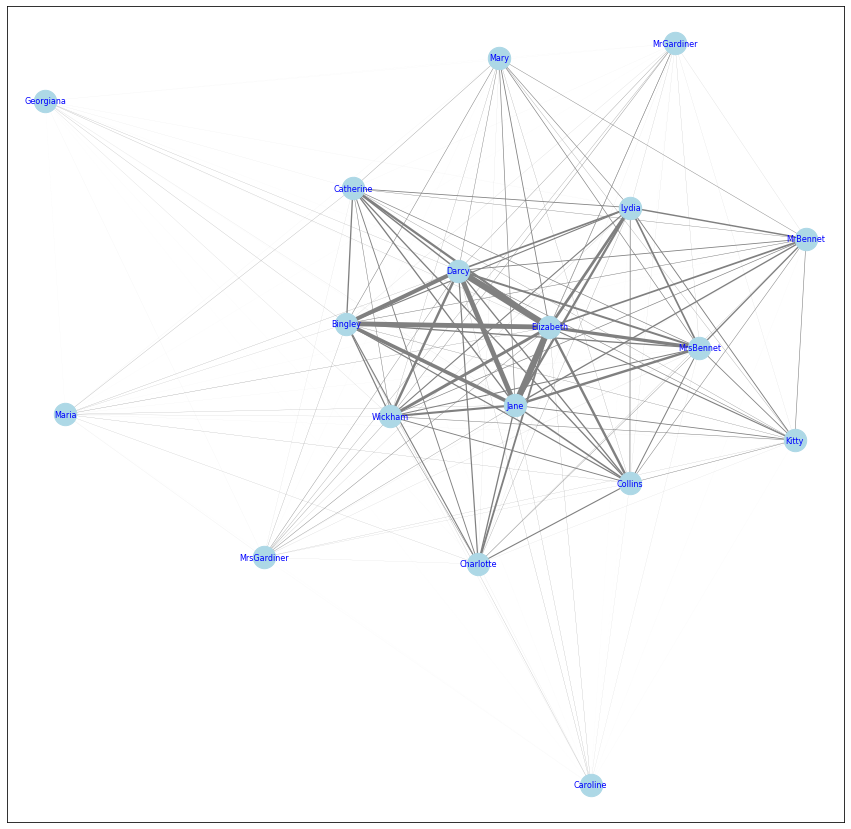

In [15]:
plt.figure(figsize=(15,15));
pos = nx.spring_layout(B_character, iterations = 50);
edges = B_character.edges()
weights = [(B_character[u][v]['weight']/20)**2 for u,v in edges]
nx.draw_networkx_nodes(B_character, pos, node_color='lightblue', node_size=500);
nx.draw_networkx_edges(B_character, pos,  edge_color='gray', width=weights);
nx.draw_networkx_labels(B_character, pos, font_size=8, font_color ='blue');

### Character degree centrality

In [16]:
char_deg_cent = {k:v for k,v in dict(nx.degree_centrality(B)).items()}
print('Character Degree Centrality ')
print('-----------------------------------------------')
for character, cdegree in sorted([(x,y) 
              for x,y in char_deg_cent.items()], 
              key=lambda x: x[1], reverse=True)[:5]:
    print('{} -'.format(character), 'Degree Centrality:',round(cdegree,3))

Character Degree Centrality 
-----------------------------------------------
Elizabeth - Degree Centrality: 0.782
Jane - Degree Centrality: 0.641
Darcy - Degree Centrality: 0.641
Bingley - Degree Centrality: 0.564
MrsBennet - Degree Centrality: 0.462


### Character betweenness centrality

In [17]:
b_bet_cent = {k:v for k,v in dict(nx.betweenness_centrality(B)).items()}
print('Character Betweenness Centrality ')
print('-----------------------------------------------')
for character, cdegree in sorted([(x,y) 
              for x,y in b_bet_cent.items()], 
              key=lambda x: x[1], reverse=True)[:5]:
    print('{} -'.format(character), 'Betweenness Centrality:',round(cdegree,3))

Character Betweenness Centrality 
-----------------------------------------------
Elizabeth - Betweenness Centrality: 0.195
Darcy - Betweenness Centrality: 0.112
Jane - Betweenness Centrality: 0.107
Bingley - Betweenness Centrality: 0.087
MrsBennet - Betweenness Centrality: 0.05


### Create function for NMF and LDA Topic Modeling

In [18]:
def NMF_LDA(text):
    maxdf = .4
    mindf = 5
    no_top_words = 10
    no_topics = 3

    tfidf_vectorizer1 = TfidfVectorizer(ngram_range=(1, 1),
                                        max_df=maxdf, 
                                        min_df=mindf, 
                                        stop_words=stop)
    tfidf1 = tfidf_vectorizer1.fit_transform(text)
    tfidf_feature_names1 = tfidf_vectorizer1.get_feature_names()

    ct_vectorizer1 = CountVectorizer(ngram_range=(1, 1),
        max_df=maxdf, min_df=mindf, stop_words=stop)
    ct1 = ct_vectorizer1.fit_transform(text)
    tf_feature_names1 = ct_vectorizer1.get_feature_names()

    # Run NMF
    nmf1 = NMF(n_components=no_topics,
               max_iter=300)
    nmf1.fit_transform(tfidf1)

    # Run LDA
    lda1 = LatentDirichletAllocation(n_components=no_topics, 
                                     max_iter=10,
                                     learning_method='online', 
                                     learning_offset=50.,
                                     random_state=0).fit(ct1)
    def display_topics(model, feature_names, no_top_words, model_used):
        topic_dict={}
        for topic_idx, topic in enumerate(model.components_):
            topic_dict["Topic:{}".format(topic_idx+1)]=" ".join(set([feature_names[i].title()
            for i in topic.argsort()[:-no_top_words - 1:-1]]))
        return pd.DataFrame.from_dict(topic_dict,
                                      orient='index')\
                                      .reset_index()\
                                      .rename(columns={'index':'Topic',
                                                       0:'Top Words'})
    
    return display_topics(nmf1, 
                          tfidf_feature_names1, 
                          no_top_words, 
                          "NMF"),\
           display_topics(lda1, 
                          tf_feature_names1, 
                          no_top_words, "LDA")

### Turn lists back into sentences

In [19]:
topic_corpus =  [' '.join(x) for x in full_corpus]

### Get NMF and LDA topics

In [20]:
NMF_LDA_Tuple = NMF_LDA(topic_corpus)

/Users/jitsen/anaconda/envs/ml-env/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning:

Maximum number of iterations 300 reached. Increase it to improve convergence.



### NMF topics

In [21]:
NMF_LDA_Tuple[0]['Top Words'].tolist()

['Little Long Letter Lady Daughter Away Day Walk Last Time',
 'Answer Pleasure Join Wedding Help Sister Mother Write Account Compliment',
 'Ever Reply Friend Love Cry Believe Indeed Man Mean Really']

### LDA topics

In [22]:
NMF_LDA_Tuple[1]['Top Words'].tolist()

['Turn Way Expect Believe Mother Sister Man Want Friend Moment',
 'Speak Room Reply Letter Lady Day Walk Seem Write Time',
 'Family Father Ever Little Pleasure Felt House Sister Saw Receive']

### Plot W2V with TSNE

In [23]:
def W2V(nlp_list):
    
    model = gensim.models.Word2Vec(nlp_list,
                                   size=100,
                                   window=10,
                                   min_count=3,
                                   workers=2)


    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
        
    tsne_model = TSNE(perplexity=30, 
                      n_components=2, 
                      init='pca', 
                      n_iter=250, 
                      angle=.8)
    
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    df = pd.DataFrame([x, y, labels]).T
    df.columns = ['x','y','label']
        
    return df

In [24]:
full_corpus = all_sentences(pride_lines[2229:-19175], include_stop=False)
w2v_df = W2V(full_corpus)

/Users/jitsen/anaconda/envs/ml-env/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [25]:
character_list = ['Elizabeth', 
                  'Darcy', 
                  'Bingley', 
                  'Catherine',
                  'MrBennet', 
                  'MrsBennet',
                  'Lydia',
                  'Wickham',
                  'Caroline',
                  'Jane',
                  'Collins',
                  'Charlotte',
                  'Kitty',
                  'Mary',
                  'Maria',
                  'Fitzwilliam',
                  'MrGardiner',
                  'MrsGardiner',
                  'Georgiana']

character_list = [x.lower() for x in character_list]

df = w2v_df[w2v_df['label'].isin(character_list)]


text_pos = [x for x in np.random.choice(['top left', 
                                         'bottom left',
                                         'top right',
                                         'bottom right'], 
                                          len(df),
                                          p=[.2,.3,.3,.2])]


trace = go.Scatter(x=df['x'],
                   y=df['y'],
                   mode='markers+text', 
                   textposition=text_pos,
                   text=df['label'],
                   textfont=dict(size=8),
                   hoverinfo='text')



fig = go.Figure([trace])

fig.update_layout(go.Layout(
    title='Word2Vec Name Vector Similarity',
    ),
    hovermode='closest',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=800,
    height=800
)

In [26]:
def sentiment_calculator(text):
    
    
    sentiment_list = []
    subjectivity_list = []
    
    for line in sent_tokenize(text):
        sentiment_tuple = TextBlob(line).sentiment
        sentiment_list.append(sentiment_tuple[0])
        subjectivity_list.append(sentiment_tuple[1])
    
    return np.mean(sentiment_list),np.mean(subjectivity_list)

In [30]:
text = find_chapters(pride_lines[6255:-19184])
sentiment_list = []
subjectivity_list = []
for chapter in ['Chapter {}'.format(x) for x in range(1, 61)]:
    text[chapter] = text[chapter].replace('Fitzwilliam', 'Darcy')\
                                 .replace('Lizzy','Elizabeth')\
                                 .replace('Mrs. Collins', 'Charlotte')\
                                 .replace('Mr. Bennet', 'MrBennet')\
                                 .replace('Mrs. Bennet', 'MrsBennet')\
                                 .replace('Mr. Gardiner', 'MrGardiner')\
                                 .replace('Mrs. Gardiner', 'MrsGardiner')
    
    sentiment_tuple = sentiment_calculator(text[chapter])
    print('{}'.format(chapter), sentiment_tuple[0], sentiment_tuple[1])
    sentiment_list.append(sentiment_tuple[0])
    subjectivity_list.append(sentiment_tuple[1])

Chapter 1 0.09968981287529674 0.46632864745767966
Chapter 2 0.167040156024531 0.4303539186507937
Chapter 3 0.24160534821519666 0.4978332932499599
Chapter 4 0.17524162946428573 0.49878158068783074
Chapter 5 0.15959196741161913 0.4450060095837459
Chapter 6 0.12082851890756302 0.46990711562402737
Chapter 7 0.06789151077097505 0.5010684169501134
Chapter 8 0.15531026237728465 0.42921365423383046
Chapter 9 0.11128375384490845 0.3610067620011358
Chapter 10 0.12352296908003427 0.3655870950707907
Chapter 11 0.06687598386462022 0.41447822379640553
Chapter 12 0.11351708913029668 0.4335313489794621
Chapter 13 0.19375633889919602 0.5467360544217686
Chapter 14 0.10800253307832673 0.433092471960726
Chapter 15 0.06826198945544183 0.4694530113577733
Chapter 16 0.053912499999999995 0.43611547619047625
Chapter 17 0.10817012970082167 0.42903753439021297
Chapter 18 0.08841071069307678 0.3858813150721633
Chapter 19 0.06807421709883832 0.3438501628842538
Chapter 20 0.12046332811453778 0.4028603184449959
Chap

In [34]:
np.mean(sentiment_list), np.mean(subjectivity_list)

(0.10664658131590124, 0.41960763190017414)

In [41]:
with open('pride_sentiment_subjectivity.pkl','wb') as f:
    pickle.dump((sentiment_list, subjectivity_list), f)

In [38]:
with open('oliver_sentiment_subjectivity.pkl','rb') as f:
    oliver_sentiment_subjectivity = pickle.load(f)

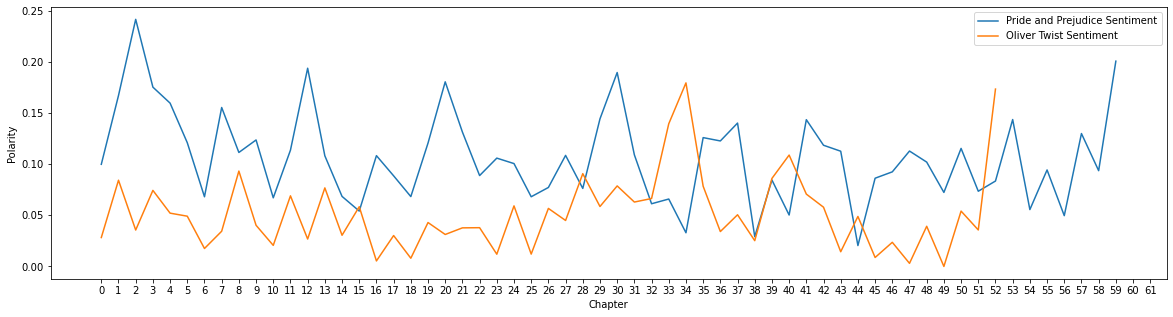

In [44]:
plt.figure(figsize=(20,5))
plt.plot(sentiment_list,label='Pride and Prejudice Sentiment');
plt.plot(oliver_sentiment_subjectivity[0], label='Oliver Twist Sentiment');
plt.ylabel('Polarity');
plt.xlabel('Chapter');
plt.xticks([x for x in range(62)])
plt.legend();